# Análisis del Modelo de Predicción de COVID-19

Este notebook contiene un análisis completo del modelo BiLSTM para predicción de casos de COVID-19 a nivel provincial.

## 1. Configuración e Importación de Librerías

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr, norm
import joblib
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Importaciones opcionales para análisis avanzado
try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.graphics.tsaplots import plot_acf
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("⚠️ statsmodels no está instalado. Algunos análisis avanzados no estarán disponibles.")
    print("   Instala con: pip install statsmodels")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


## 2. Cargar Modelo y Componentes

In [6]:

MODEL_DIR = "models"
MODEL_PATH = f"{MODEL_DIR}/bilstm_covid_provincial.h5"
SCALER_PATH = f"{MODEL_DIR}/scaler_covid_provincial.pkl"

# Cargar modelo
print("📦 Cargando modelo...")
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
print(f"✅ Modelo cargado: {model.input_shape} -> {model.output_shape}")

# Cargar scaler
print("📦 Cargando scaler...")
scaler = joblib.load(SCALER_PATH)
print("✅ Scaler cargado")

# Información del modelo
print(f"\n📊 Arquitectura del modelo:")
model.summary()


📦 Cargando modelo...
✅ Modelo cargado: (None, 14, 6) -> (None, 1)
📦 Cargando scaler...
✅ Scaler cargado

📊 Arquitectura del modelo:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 14, 128)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,681 (311.25 KB)

 Trainable params: 79,681 (311.25 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Cargar Dataset Original y Preparar Datos

*Importante: Carga el mismo CSV que usaste para entrenar el modelo*

In [7]:

# Cargar datos del CSV original usado para entrenar
# IMPORTANTE: Usa el mismo CSV que usaste para entrenar el modelo
# Ejemplo: df_geo = pd.read_csv("covid_ubigeo.csv", parse_dates=["fecha"])

# Si no tienes el CSV, descomenta y ajusta la ruta:
# df_geo = pd.read_csv("ruta/a/tu/archivo.csv", parse_dates=["fecha"])

# Para este ejemplo, intentaremos cargar el CSV original
try:
    df_geo = pd.read_csv("covid_ubigeo.csv", parse_dates=["fecha"])
    print("✅ CSV original cargado: covid_ubigeo.csv")
except FileNotFoundError:
    print("⚠️ ADVERTENCIA: No se encontró el CSV original")
    print("⚠️ REEMPLAZA este código con la carga de tus datos reales del CSV de entrenamiento")
    print("⚠️ El modelo fue entrenado con datos agrupados por provincia con casos_vecinos")
    
    # Generar datos sintéticos de ejemplo (SOLO PARA DEMOSTRACIÓN)
    dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
    np.random.seed(42)
    df_geo = pd.DataFrame({
        'fecha': dates,
        'departamento': ['LIMA'] * len(dates),
        'provincia': ['LIMA'] * len(dates),
        'casos': np.random.poisson(50, len(dates)),
        'latitud': -12.0464,
        'longitud': -77.0428
    })
    print("⚠️ Usando datos sintéticos para demostración")

# Normalizar textos
for col in ["departamento", "provincia"]:
    if col in df_geo.columns:
        df_geo[col] = df_geo[col].astype(str).str.strip().str.upper()

# Crear clave única de provincia
df_geo["key_prov"] = df_geo["departamento"] + "|" + df_geo["provincia"]

# Agregar calendario si falta
if "mes" not in df_geo.columns:
    df_geo["mes"] = df_geo["fecha"].dt.month
if "dia_semana" not in df_geo.columns:
    df_geo["dia_semana"] = df_geo["fecha"].dt.weekday
if "semana_anio" not in df_geo.columns:
    df_geo["semana_anio"] = df_geo["fecha"].dt.isocalendar().week.astype(int)
if "trimestre" not in df_geo.columns:
    df_geo["trimestre"] = df_geo["fecha"].dt.quarter

print(f"✅ Datos cargados: {df_geo.shape}")
print(f"   Columnas: {list(df_geo.columns)}")
df_geo.head()


✅ CSV original cargado: covid_ubigeo.csv
✅ Datos cargados: (2210746, 14)
   Columnas: ['fecha', 'departamento', 'provincia', 'distrito', 'casos', 'anio', 'mes', 'dia_anio', 'dia_semana', 'semana_anio', 'trimestre', 'latitud', 'longitud', 'key_prov']


,fecha,departamento,provincia,distrito,casos,anio,mes,dia_anio,dia_semana,semana_anio,trimestre,latitud,longitud,key_prov
0,2020-03-06,AMAZONAS,BAGUA,ARAMANGO,0,2020,3,66,4,10,1,-5.4164,-78.4378,AMAZONAS|BAGUA
1,2020-03-06,AMAZONAS,BAGUA,BAGUA,0,2020,3,66,4,10,1,-5.6389,-78.5311,AMAZONAS|BAGUA
2,2020-03-06,AMAZONAS,BAGUA,COPALLIN,0,2020,3,66,4,10,1,-5.6750,-78.4231,AMAZONAS|BAGUA
3,2020-03-06,AMAZONAS,BAGUA,EL PARCO,0,2020,3,66,4,10,1,-5.6250,-78.4753,AMAZONAS|BAGUA
4,2020-03-06,AMAZONAS,BAGUA,IMAZA,0,2020,3,66,4,10,1,-5.1636,-78.2889,AMAZONAS|BAGUA


## 4. Preparar Datos por Provincia y Calcular Casos Vecinos

In [8]:

from sklearn.metrics import pairwise_distances

K_VECINOS = 3  # Número de provincias vecinas

# Agregar a nivel PROVINCIA-DÍA
df_prov = (
    df_geo.groupby(["fecha", "departamento", "provincia", "key_prov"], as_index=False)
          .agg({
              "casos": "sum",
              "mes": "first",
              "dia_semana": "first",
              "semana_anio": "first",
              "trimestre": "first"
          })
          .sort_values(["key_prov", "fecha"])
          .reset_index(drop=True)
)

# Calcular centroides por provincia
coords_prov = (
    df_geo.groupby("key_prov", as_index=False)
          .agg({"latitud": "mean", "longitud": "mean"})
)

keys_prov = coords_prov["key_prov"].values
coords = coords_prov[["latitud", "longitud"]].values

# Calcular distancias y vecinos
try:
    dist_matrix = pairwise_distances(coords, metric="euclidean")
    neighbors_idx = np.argsort(dist_matrix, axis=1)[:, 1:K_VECINOS+1]
    
    neighbor_map = {
        key: keys_prov[neighbors_idx[i]].tolist()
        for i, key in enumerate(keys_prov)
    }
    
    # Calcular casos_vecinos
    pivot_casos = df_prov.pivot(
        index="fecha",
        columns="key_prov",
        values="casos"
    ).fillna(0)
    
    pivot_vecinos = pd.DataFrame(index=pivot_casos.index)
    
    for key in keys_prov:
        vecinos = neighbor_map.get(key, [])
        vecinos_validos = [v for v in vecinos if v in pivot_casos.columns]
        if len(vecinos_validos) == 0:
            pivot_vecinos[key] = 0
        else:
            pivot_vecinos[key] = pivot_casos[vecinos_validos].sum(axis=1)
    
    df_vecinos = (
        pivot_vecinos.stack()
                     .reset_index()
                     .rename(columns={"level_1": "key_prov", 0: "casos_vecinos"})
    )
    
    df_prov = df_prov.merge(df_vecinos, on=["fecha", "key_prov"], how="left")
    df_prov["casos_vecinos"] = df_prov["casos_vecinos"].fillna(0)
    
    print("✅ Casos vecinos calculados correctamente")
except Exception as e:
    print(f"⚠️ Error calculando casos_vecinos: {e}")
    print("   Usando valores sintéticos")
    df_prov["casos_vecinos"] = df_prov["casos"] * 3  # Aproximación simple

print(f"✅ Datos por provincia preparados: {df_prov.shape}")
df_prov.head()


✅ Casos vecinos calculados correctamente
✅ Datos por provincia preparados: (233710, 10)


,fecha,departamento,provincia,key_prov,casos,mes,dia_semana,semana_anio,trimestre,casos_vecinos
0,2020-03-06,AMAZONAS,BAGUA,AMAZONAS|BAGUA,0,3,4,10,1,0.0
1,2020-03-07,AMAZONAS,BAGUA,AMAZONAS|BAGUA,0,3,5,10,1,0.0
2,2020-03-08,AMAZONAS,BAGUA,AMAZONAS|BAGUA,0,3,6,10,1,0.0
3,2020-03-09,AMAZONAS,BAGUA,AMAZONAS|BAGUA,0,3,0,11,1,0.0
4,2020-03-10,AMAZONAS,BAGUA,AMAZONAS|BAGUA,0,3,1,11,1,0.0


## 5. Crear Secuencias Agrupadas por Provincia

In [9]:

WINDOW_SIZE = 14     # días de historial
HORIZON = 1          # predecimos 1 día adelante

# Variables de entrada
feature_cols = ["casos", "casos_vecinos", "mes", "dia_semana", "semana_anio", "trimestre"]
FEATURES = feature_cols  # Para compatibilidad con código posterior

def make_sequences(df_grouped, window_size, horizon):
    """
    Crea ventanas deslizantes por provincia.
    Para cada provincia:
      X: [window_size, n_features]
      y: [horizon] (casos futuros)
    Devuelve:
      X: np.array [N_samples, window_size, n_features]
      y: np.array [N_samples, horizon]
      dates_arr: fecha del target (último paso del horizonte)
      keys_arr: llave (key_prov) de cada muestra
    """
    X_list, y_list = [], []
    dates_list, keys_list = [], []

    for key, g in df_grouped:
        g = g.sort_values("fecha")
        values = g[feature_cols].values
        target = g["casos"].values
        dates = g["fecha"].values  # fechas

        n = len(g)
        max_i = n - window_size - horizon + 1
        if max_i <= 0:
            continue  # serie demasiado corta

        for i in range(max_i):
            x = values[i : i + window_size]
            y = target[i + window_size : i + window_size + horizon]

            X_list.append(x)
            y_list.append(y)
            dates_list.append(dates[i + window_size + horizon - 1])
            keys_list.append(key)

    X = np.stack(X_list)
    y = np.stack(y_list).astype("float32")
    dates_arr = np.array(dates_list)
    keys_arr = np.array(keys_list, dtype=object)

    return X, y, dates_arr, keys_arr

# Crear secuencias agrupadas por provincia
X, y, seq_dates, seq_keys = make_sequences(
    df_prov.groupby("key_prov"),
    window_size=WINDOW_SIZE,
    horizon=HORIZON,
)

print(f"✅ Secuencias creadas: {X.shape}")
print(f"   Total muestras: {len(X)}")
print(f"   Ventana: {WINDOW_SIZE} días")
print(f"   Features: {len(feature_cols)}")


✅ Secuencias creadas: (230966, 14, 6)
   Total muestras: 230966
   Ventana: 14 días
   Features: 6


## 6. Split Temporal 80/20 (Train/Test)

In [10]:

# Split 80% / 20% SIN mezclar tiempos
# - Ordenamos todas las secuencias por fecha de target
# - Primer 80% -> entrenamiento (usado para entrenar el modelo)
# - Último 20% -> test (usado para evaluación)

# Convertir fechas a tipo datetime64 si aún no lo están
seq_dates = pd.to_datetime(seq_dates)

# Orden global por fecha del target
order = np.argsort(seq_dates)
X_ord = X[order]
y_ord = y[order]
dates_ord = seq_dates[order]
keys_ord = seq_keys[order]

# Índice de corte 80/20
cut = int(0.8 * len(dates_ord))

X_train, X_test = X_ord[:cut], X_ord[cut:]
y_train, y_test = y_ord[:cut], y_ord[cut:]
dates_train, dates_test = dates_ord[:cut], dates_ord[cut:]
keys_train, keys_test = keys_ord[:cut], keys_ord[cut:]

print("Total muestras:", len(dates_ord))
print("Train (80%):", X_train.shape, y_train.shape, "hasta", dates_train[-1])
print("Test  (20%):", X_test.shape,  y_test.shape,  "desde", dates_test[0])

# Usar el conjunto de TEST para evaluación (último 20%)
X_val = X_test
y_val = y_test
dates_val = dates_test
keys_val = keys_test


Total muestras: 230966
Train (80%): (184772, 14, 6) (184772, 1) hasta 2022-10-18 00:00:00
Test  (20%): (46194, 14, 6) (46194, 1) desde 2022-10-18 00:00:00


## 7. Escalar Datos de Test

In [11]:

# Escalar usando el scaler guardado (entrenado con datos de train)
# El scaler fue entrenado SOLO con X_train, ahora lo aplicamos a X_test
X_val_scaled = scaler.transform(X_val.reshape(-1, len(feature_cols))).reshape(X_val.shape)

print(f"✅ Datos escalados: {X_val_scaled.shape}")
print(f"   Usando scaler entrenado con datos de entrenamiento")


✅ Datos escalados: (46194, 14, 6)
   Usando scaler entrenado con datos de entrenamiento


## 8. Generar Predicciones

In [12]:

print("🔮 Generando predicciones...")
y_pred = model.predict(X_val_scaled, verbose=0).ravel()

print(f"✅ Predicciones generadas: {len(y_pred)}")
print(f"   Rango real: [{y_val.min():.2f}, {y_val.max():.2f}]")
print(f"   Rango predicho: [{y_pred.min():.2f}, {y_pred.max():.2f}]")


🔮 Generando predicciones...
✅ Predicciones generadas: 46194
   Rango real: [0.00, 7783.00]
   Rango predicho: [0.04, 7.66]


## 9. Métricas de Evaluación

In [13]:

# Asegurar que y_val y y_pred tengan la misma longitud
y_val = np.asarray(y_val).ravel()
y_pred = np.asarray(y_pred).ravel()

# Ajustar longitudes si son diferentes
min_len = min(len(y_val), len(y_pred))
if len(y_val) != len(y_pred):
    print(f"⚠️ ADVERTENCIA: Longitudes diferentes - y_val: {len(y_val)}, y_pred: {len(y_pred)}")
    print(f"   Usando los primeros {min_len} valores de ambos")
    y_val = y_val[:min_len]
    y_pred = y_pred[:min_len]

# Calcular métricas básicas
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

# Métricas adicionales
errors = y_val - y_pred
bias = np.mean(errors)
medae = median_absolute_error(y_val, y_pred)

# NRMSE (normalizado por rango y por media)
range_y = y_val.max() - y_val.min()
mean_y = y_val.mean()
nrmse_range = (rmse / (range_y + 1e-8)) * 100.0 if range_y > 0 else 0
nrmse_mean = (rmse / (mean_y + 1e-8)) * 100.0 if mean_y > 0 else 0

# sMAPE (Symmetric MAPE)
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + 1e-8
    return np.mean(num / den) * 100.0

smape_val = smape(y_val, y_pred)

# MASE (Mean Absolute Scaled Error) - comparado con naive estacional
def mase(y_true, y_pred, m=52):
    '''MASE usando naive estacional con periodo m (52 semanas ~ 1 año)'''
    y = np.asarray(y_true)
    if len(y) <= m:
        return np.nan
    scale = np.mean(np.abs(y[m:] - y[:-m]))
    return np.mean(np.abs(y_true - y_pred)) / (scale + 1e-8)

mase_val = mase(y_val, y_pred, m=52)

# Correlaciones (con validación adicional)
try:
    if len(y_val) >= 2 and len(y_pred) >= 2 and len(y_val) == len(y_pred):
        pearson_r, pearson_p = pearsonr(y_val, y_pred)
        spearman_rho, spearman_p = spearmanr(y_val, y_pred)
    else:
        print("⚠️ No se pueden calcular correlaciones: longitudes insuficientes o diferentes")
        pearson_r, pearson_p = np.nan, np.nan
        spearman_rho, spearman_p = np.nan, np.nan
except Exception as e:
    print(f"⚠️ Error calculando correlaciones: {e}")
    pearson_r, pearson_p = np.nan, np.nan
    spearman_rho, spearman_p = np.nan, np.nan

# Crear DataFrame con métricas
metrics_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE (%)', 'sMAPE (%)', 'MASE', 
                'Bias', 'MedAE', 'NRMSE (rango %)', 'NRMSE (media %)',
                'Pearson r', 'Spearman ρ'],
    'Valor': [mae, mse, rmse, r2, mape*100, smape_val, mase_val,
              bias, medae, nrmse_range, nrmse_mean,
              pearson_r, spearman_rho]
})

print("📊 MÉTRICAS DE EVALUACIÓN COMPLETAS")
print("=" * 60)
for _, row in metrics_df.iterrows():
    print(f"{row['Métrica']:20s}: {row['Valor']:12.4f}")

print(f"\n📈 Correlaciones:")
print(f"   Pearson r:   {pearson_r:.4f}  (p={pearson_p:.3e})")
print(f"   Spearman ρ: {spearman_rho:.4f}  (p={spearman_p:.3e})")

metrics_df


📊 MÉTRICAS DE EVALUACIÓN COMPLETAS
MAE                 :       6.7206
MSE                 :   14808.6807
RMSE                :     121.6909
R²                  :       0.0016
MAPE (%)            : 50792135602995200.0000
sMAPE (%)           :     176.6277
MASE                :       0.5229
Bias                :       6.4863
MedAE               :       0.1418
NRMSE (rango %)     :       1.5635
NRMSE (media %)     :    1751.6867
Pearson r           :       0.3380
Spearman ρ          :       0.6321

📈 Correlaciones:
   Pearson r:   0.3380  (p=0.000e+00)
   Spearman ρ: 0.6321  (p=0.000e+00)


,Métrica,Valor
0,MAE,6.720596e+00
1,MSE,1.480868e+04
2,RMSE,1.216909e+02
3,R²,1.562774e-03
4,MAPE (%),5.079214e+16
5,sMAPE (%),1.766277e+02
6,MASE,5.229257e-01
7,Bias,6.486283e+00
8,MedAE,1.418403e-01
9,NRMSE (rango %),1.563548e+00


## 9.1 Comparación con Modelo Naive

In [14]:

# Asegurar que y_val y y_pred tengan la misma longitud (ya ajustados arriba)
# Comparación con modelo Naive (Random Walk)
# Naive: predice el mismo valor que la semana anterior
y_naive = np.roll(y_val, 1)
y_naive[0] = y_val[0]  # Primera muestra sin anterior

# Calcular métricas del naive
mae_naive = mean_absolute_error(y_val, y_naive)
rmse_naive = np.sqrt(mean_squared_error(y_val, y_naive))
r2_naive = r2_score(y_val, y_naive)
mape_naive = mean_absolute_percentage_error(y_val, y_naive)

# Diebold-Mariano test para comparar modelos
def diebold_mariano_test(y_true, y_pred1, y_pred0, h=1):
    '''Test de Diebold-Mariano comparando modelo 1 vs modelo 0 (baseline)'''
    y_true = np.asarray(y_true).reshape(-1)
    y_pred1 = np.asarray(y_pred1).reshape(-1)
    y_pred0 = np.asarray(y_pred0).reshape(-1)
    
    # Diferencia de pérdidas (squared error)
    e1 = y_true - y_pred1
    e0 = y_true - y_pred0
    d = e1**2 - e0**2
    
    T = len(d)
    d_bar = d.mean()
    
    # Autocovarianzas hasta lag h-1 (Newey–West)
    gamma = []
    for k in range(h):
        if k == 0:
            gamma_k = np.sum((d - d_bar) * (d - d_bar)) / T
        else:
            gamma_k = np.sum((d[k:] - d_bar) * (d[:-k] - d_bar)) / T
        gamma.append(gamma_k)
    
    var_d = gamma[0] + 2 * np.sum(gamma[1:])
    dm_stat = d_bar / np.sqrt(var_d / T + 1e-8)
    
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    return p_value

dm_p = diebold_mariano_test(y_val, y_pred, y_naive, h=1)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Modelo': ['Naive (RW)', 'BiLSTM'],
    'MAE': [mae_naive, mae],
    'RMSE': [rmse_naive, rmse],
    'R²': [r2_naive, r2],
    'MAPE (%)': [mape_naive*100, mape*100]
})

print("\n📊 COMPARACIÓN CON MODELO NAIVE (Random Walk)")
print("=" * 60)
print(comparison_df.to_string(index=False))
print(f"\n🔬 Test de Diebold-Mariano (BiLSTM vs Naive):")
print(f"   p-value: {dm_p:.4f}")
if dm_p < 0.05:
    print("   ✅ El modelo BiLSTM es significativamente mejor (p < 0.05)")
else:
    print("   ⚠️ No hay diferencia significativa (p >= 0.05)")

comparison_df



📊 COMPARACIÓN CON MODELO NAIVE (Random Walk)
    Modelo       MAE       RMSE        R²     MAPE (%)
Naive (RW) 12.790276 171.858283 -0.991340 1.204509e+18
    BiLSTM  6.720596 121.690923  0.001563 5.079214e+16

🔬 Test de Diebold-Mariano (BiLSTM vs Naive):
   p-value: 0.0000
   ✅ El modelo BiLSTM es significativamente mejor (p < 0.05)


,Modelo,MAE,RMSE,R²,MAPE (%)
0,Naive (RW),12.790276,171.858283,-0.991340,1.204509e+18
1,BiLSTM,6.720596,121.690923,0.001563,5.079214e+16


## 9.2 Análisis de Calidad del Modelo

📊 ANÁLISIS DE CALIDAD DEL MODELO

1️⃣ TEST DE NORMALIDAD DE RESIDUOS
----------------------------------------------------------------------

   D'Agostino-Pearson Test:
   • Estadístico: 138718.5469
   • p-value: 0.0000e+00
   ⚠️ Los residuos NO siguen una distribución normal (p <= 0.05)

2️⃣ ANÁLISIS DE ESTABILIDAD TEMPORAL
----------------------------------------------------------------------
   MAE por Período Temporal:
   • Inicial: 17.7984
   • Medio: 1.2896
   • Final: 1.1314
   ⚠️ Modelo inestable (CV = 1.421 >= 0.5)

3️⃣ PERFORMANCE POR RANGOS DE VALORES
----------------------------------------------------------------------
   MAE por Rango de Valores Reales:
   • Bajo: 4.2644
   • Medio: 3637.7295
   • Alto: 6920.2334
   ⚠️ El modelo tiene performance variable según el rango de valores

4️⃣ ANÁLISIS DE VARIANZA DE RESIDUOS
----------------------------------------------------------------------
   • Varianza de residuos: 14766.6094
   • Media de |residuos|: 6.7206
   • Coeficien

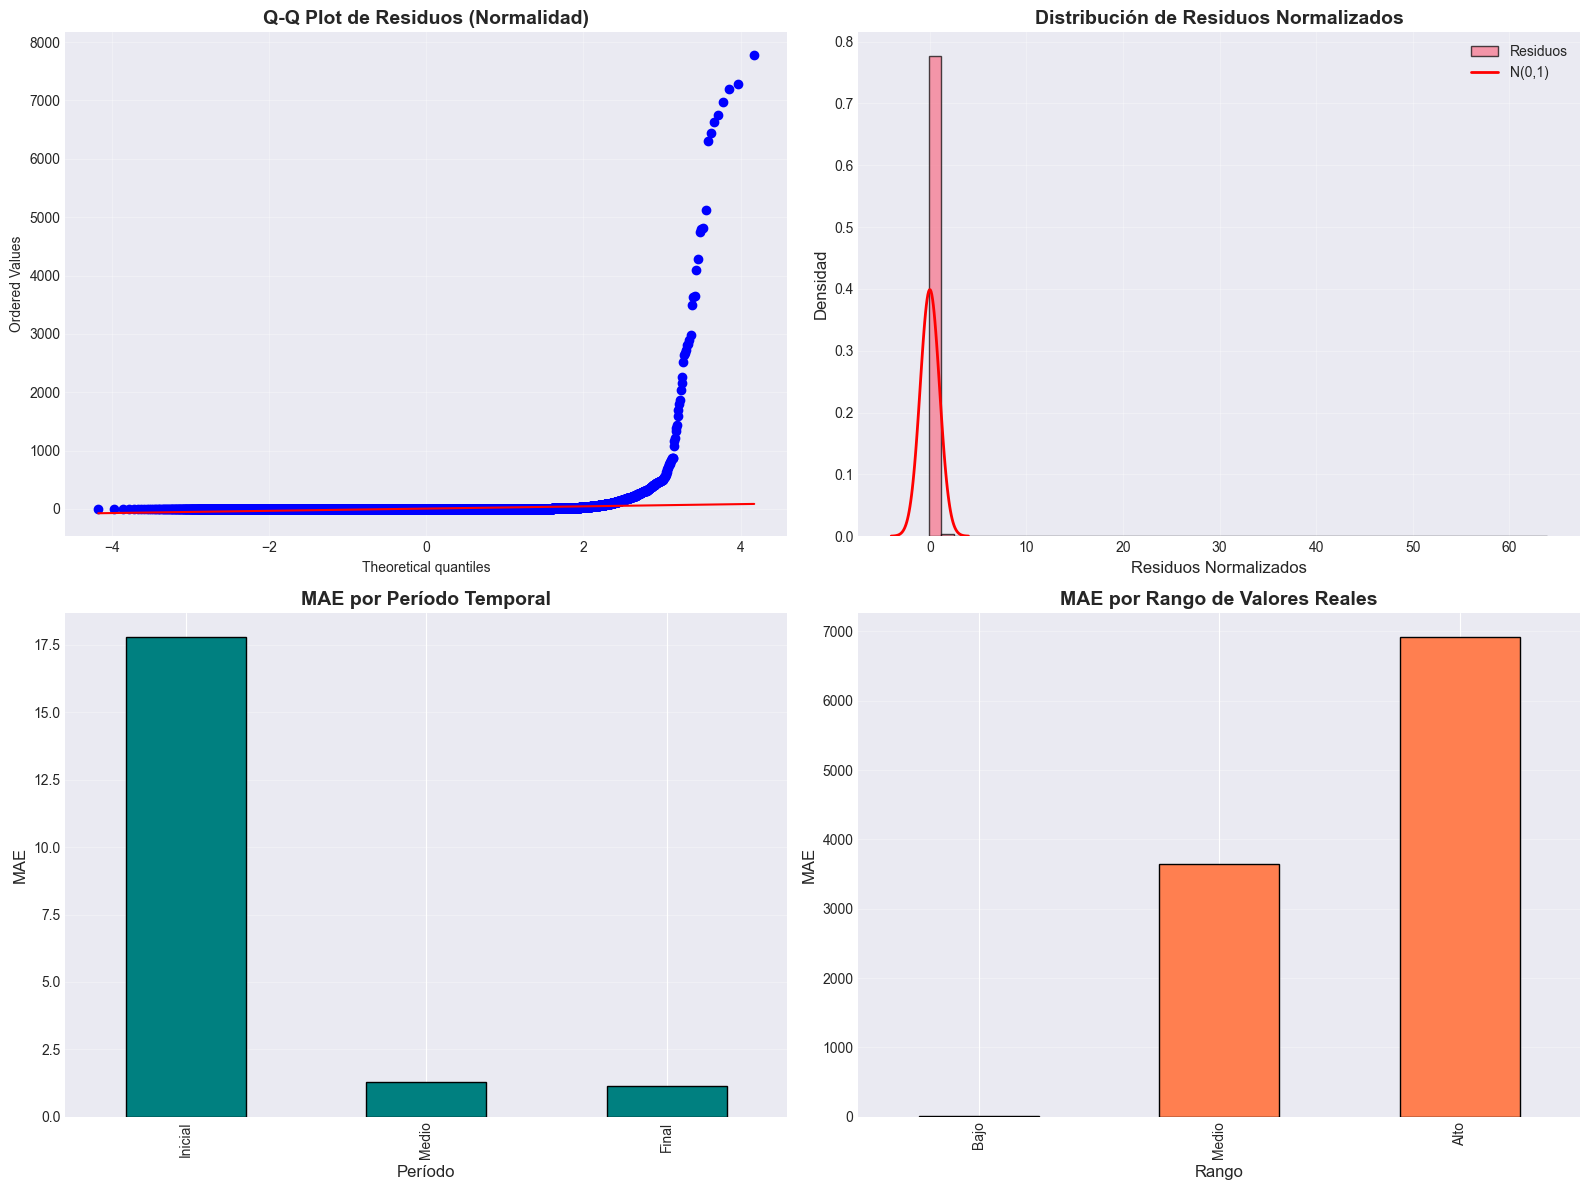


✅ Análisis de calidad completado


In [15]:

# Análisis de Calidad del Modelo
from scipy.stats import shapiro, normaltest

resid = y_val - y_pred
resid_normalized = (resid - resid.mean()) / (resid.std() + 1e-8)

print("=" * 70)
print("📊 ANÁLISIS DE CALIDAD DEL MODELO")
print("=" * 70)

# 1. Test de Normalidad de Residuos
print("\n1️⃣ TEST DE NORMALIDAD DE RESIDUOS")
print("-" * 70)
try:
    # Test de Shapiro-Wilk (para muestras pequeñas/medianas)
    if len(resid) <= 5000:
        stat_shapiro, p_shapiro = shapiro(resid)
        print(f"   Shapiro-Wilk Test:")
        print(f"   • Estadístico: {stat_shapiro:.4f}")
        print(f"   • p-value: {p_shapiro:.4e}")
        if p_shapiro > 0.05:
            print("   ✅ Los residuos siguen una distribución normal (p > 0.05)")
        else:
            print("   ⚠️ Los residuos NO siguen una distribución normal (p <= 0.05)")
    
    # Test de D'Agostino-Pearson (para muestras grandes)
    stat_dagostino, p_dagostino = normaltest(resid)
    print(f"\n   D'Agostino-Pearson Test:")
    print(f"   • Estadístico: {stat_dagostino:.4f}")
    print(f"   • p-value: {p_dagostino:.4e}")
    if p_dagostino > 0.05:
        print("   ✅ Los residuos siguen una distribución normal (p > 0.05)")
    else:
        print("   ⚠️ Los residuos NO siguen una distribución normal (p <= 0.05)")
except Exception as e:
    print(f"   ⚠️ Error en tests de normalidad: {e}")

# 2. Análisis de Estabilidad Temporal
print("\n2️⃣ ANÁLISIS DE ESTABILIDAD TEMPORAL")
print("-" * 70)
if 'dates_val' in locals() and len(dates_val) == len(resid):
    df_temp = pd.DataFrame({
        'fecha': pd.to_datetime(dates_val),
        'error': np.abs(resid)
    })
    df_temp['periodo'] = pd.cut(
        pd.to_numeric(df_temp['fecha']), 
        bins=3, 
        labels=['Inicial', 'Medio', 'Final']
    )
    
    mae_por_periodo = df_temp.groupby('periodo')['error'].mean()
    print("   MAE por Período Temporal:")
    for periodo, mae_per in mae_por_periodo.items():
        print(f"   • {periodo}: {mae_per:.4f}")
    
    # Calcular variabilidad
    cv = mae_por_periodo.std() / mae_por_periodo.mean()
    if cv < 0.2:
        print(f"   ✅ Modelo estable (CV = {cv:.3f} < 0.2)")
    elif cv < 0.5:
        print(f"   ⚠️ Modelo moderadamente estable (CV = {cv:.3f})")
    else:
        print(f"   ⚠️ Modelo inestable (CV = {cv:.3f} >= 0.5)")
else:
    print("   ⚠️ No se pudo realizar análisis temporal (fechas no disponibles)")

# 3. Análisis de Performance por Rangos de Valores
print("\n3️⃣ PERFORMANCE POR RANGOS DE VALORES")
print("-" * 70)
df_ranges = pd.DataFrame({
    'real': y_val,
    'pred': y_pred,
    'error': np.abs(resid)
})

# Intentar usar qcut, si falla usar cut
try:
    # Intentar usar qcut, si falla usar cut
    try:
        df_ranges['rango'] = pd.qcut(y_val, q=3, labels=['Bajo', 'Medio', 'Alto'], duplicates='drop')
    except ValueError:
        # Si qcut falla (valores duplicados), usar cut
        df_ranges['rango'] = pd.cut(y_val, bins=3, labels=['Bajo', 'Medio', 'Alto'])
except Exception as e:
    print(f"   ⚠️ Error creando rangos: {e}")
    # Crear rangos manualmente
    terciles = np.percentile(y_val, [33.33, 66.67])
    df_ranges['rango'] = pd.cut(y_val, bins=[-np.inf, terciles[0], terciles[1], np.inf], 
                                labels=['Bajo', 'Medio', 'Alto'])

mae_por_rango = df_ranges.groupby('rango')['error'].mean()
print("   MAE por Rango de Valores Reales:")
for rango, mae_r in mae_por_rango.items():
    print(f"   • {rango}: {mae_r:.4f}")

# Verificar si el error es similar en todos los rangos
if len(mae_por_rango) > 0 and mae_por_rango.std() / (mae_por_rango.mean() + 1e-8) < 0.3:
    print("   ✅ El modelo tiene performance consistente en todos los rangos")
else:
    print("   ⚠️ El modelo tiene performance variable según el rango de valores")

# 4. Análisis de Varianza de Residuos
print("\n4️⃣ ANÁLISIS DE VARIANZA DE RESIDUOS")
print("-" * 70)
var_resid = np.var(resid)
mean_abs_resid = np.mean(np.abs(resid))
cv_resid = np.std(resid) / (np.abs(np.mean(resid)) + 1e-8)

print(f"   • Varianza de residuos: {var_resid:.4f}")
print(f"   • Media de |residuos|: {mean_abs_resid:.4f}")
print(f"   • Coeficiente de variación: {cv_resid:.4f}")

if cv_resid < 1.0:
    print("   ✅ Baja variabilidad en los residuos (modelo preciso)")
elif cv_resid < 2.0:
    print("   ⚠️ Variabilidad moderada en los residuos")
else:
    print("   ⚠️ Alta variabilidad en los residuos (modelo impreciso)")

# 5. Visualizaciones de Calidad
print("\n5️⃣ VISUALIZACIONES DE CALIDAD")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Q-Q Plot para normalidad
from scipy import stats
stats.probplot(resid, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Q-Q Plot de Residuos (Normalidad)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histograma de residuos normalizados
axes[0, 1].hist(resid_normalized, bins=50, density=True, alpha=0.7, edgecolor='black', label='Residuos')
x_norm = np.linspace(-4, 4, 100)
axes[0, 1].plot(x_norm, stats.norm.pdf(x_norm, 0, 1), 'r-', lw=2, label='N(0,1)')
axes[0, 1].set_title('Distribución de Residuos Normalizados', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residuos Normalizados', fontsize=12)
axes[0, 1].set_ylabel('Densidad', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAE por período temporal
if 'dates_val' in locals() and len(dates_val) == len(resid):
    mae_por_periodo.plot(kind='bar', ax=axes[1, 0], color='teal', edgecolor='black')
    axes[1, 0].set_title('MAE por Período Temporal', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Período', fontsize=12)
    axes[1, 0].set_ylabel('MAE', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 0].text(0.5, 0.5, 'Datos temporales no disponibles', 
                     ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('MAE por Período Temporal', fontsize=14, fontweight='bold')

# MAE por rango de valores
mae_por_rango.plot(kind='bar', ax=axes[1, 1], color='coral', edgecolor='black')
axes[1, 1].set_title('MAE por Rango de Valores Reales', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Rango', fontsize=12)
axes[1, 1].set_ylabel('MAE', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ Análisis de calidad completado")
print("=" * 70)


## 10. Visualizaciones

### 10.1 Predicciones vs Valores Reales

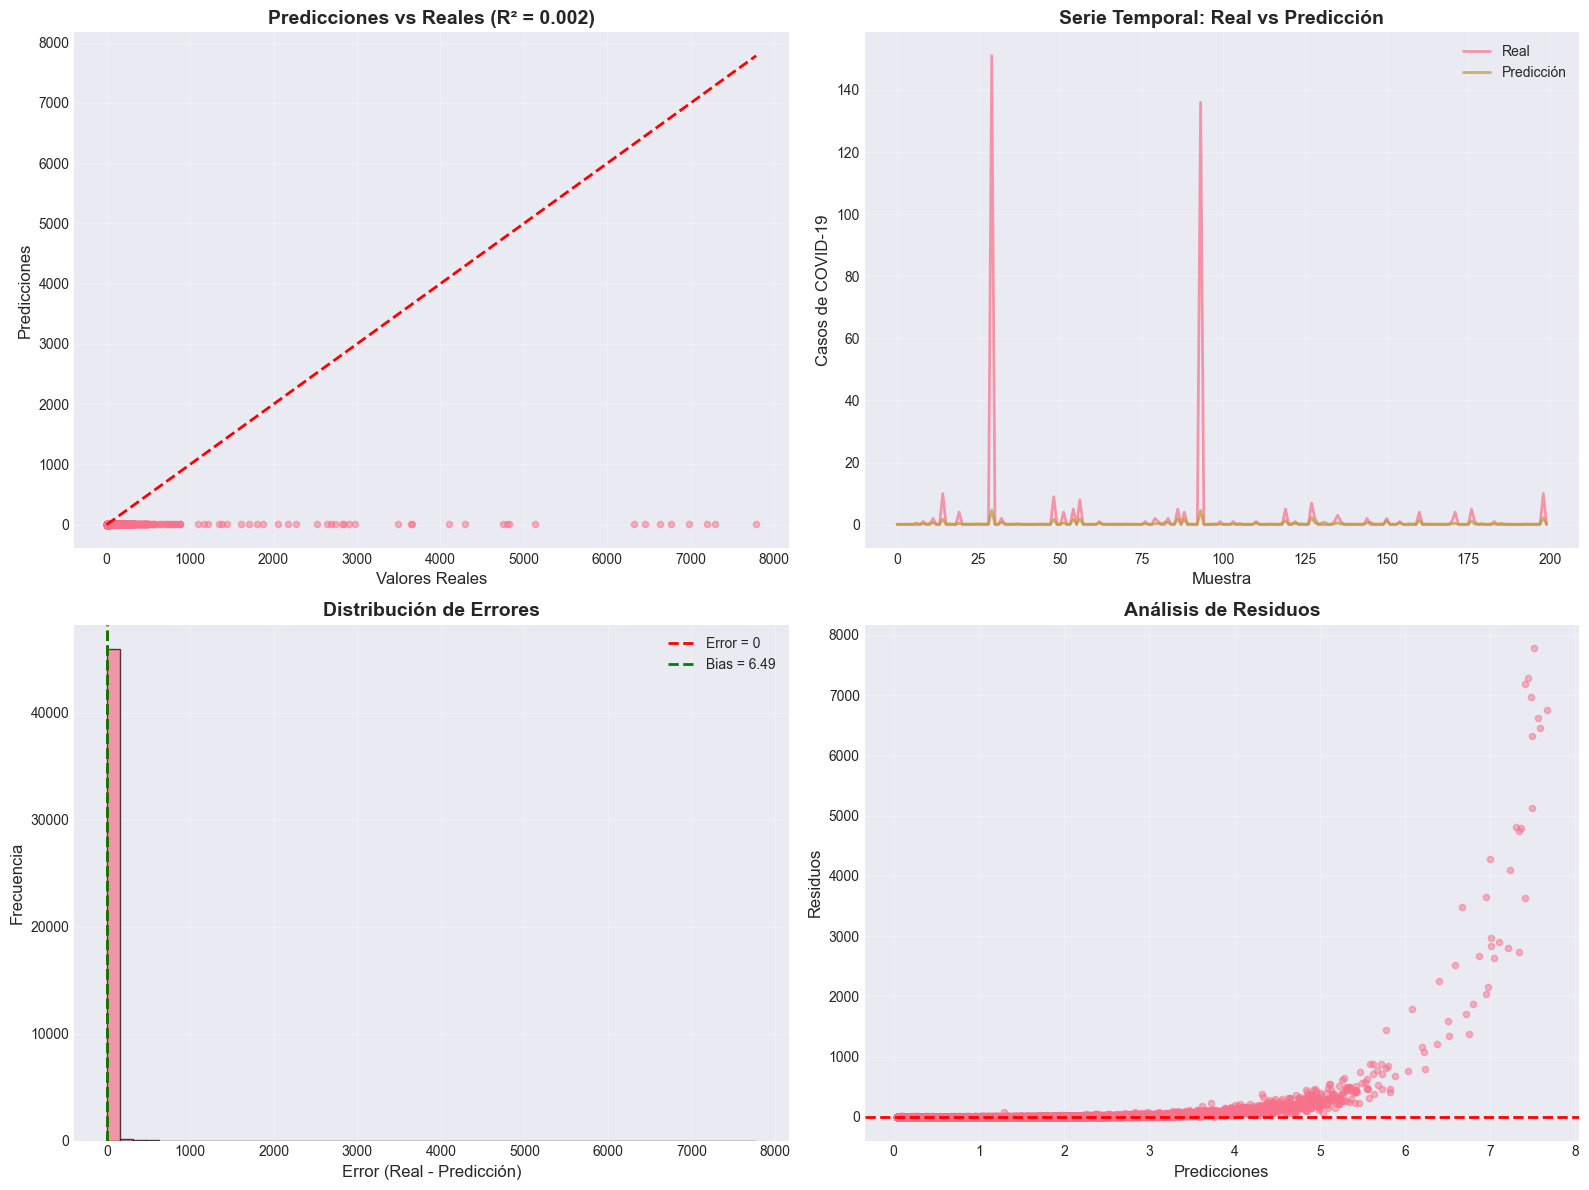

✅ Gráficos generados


In [16]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Predicciones vs Reales (Scatter)
axes[0, 0].scatter(y_val, y_pred, alpha=0.5, s=20)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valores Reales', fontsize=12)
axes[0, 0].set_ylabel('Predicciones', fontsize=12)
axes[0, 0].set_title(f'Predicciones vs Reales (R² = {r2:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Serie temporal
sample_size = min(200, len(y_val))
indices = np.arange(sample_size)
axes[0, 1].plot(indices, y_val[:sample_size], label='Real', linewidth=2, alpha=0.7)
axes[0, 1].plot(indices, y_pred[:sample_size], label='Predicción', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Muestra', fontsize=12)
axes[0, 1].set_ylabel('Casos de COVID-19', fontsize=12)
axes[0, 1].set_title('Serie Temporal: Real vs Predicción', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Distribución de Errores
axes[1, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='r', linestyle='--', linewidth=2, label='Error = 0')
axes[1, 0].axvline(bias, color='g', linestyle='--', linewidth=2, label=f'Bias = {bias:.2f}')
axes[1, 0].set_xlabel('Error (Real - Predicción)', fontsize=12)
axes[1, 0].set_ylabel('Frecuencia', fontsize=12)
axes[1, 0].set_title('Distribución de Errores', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Residuos vs Predicciones
axes[1, 1].scatter(y_pred, errors, alpha=0.5, s=20)
axes[1, 1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicciones', fontsize=12)
axes[1, 1].set_ylabel('Residuos', fontsize=12)
axes[1, 1].set_title('Análisis de Residuos', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Gráficos generados")


### 10.2 Análisis de Impacto de Casos Vecinos (COVID Específico)

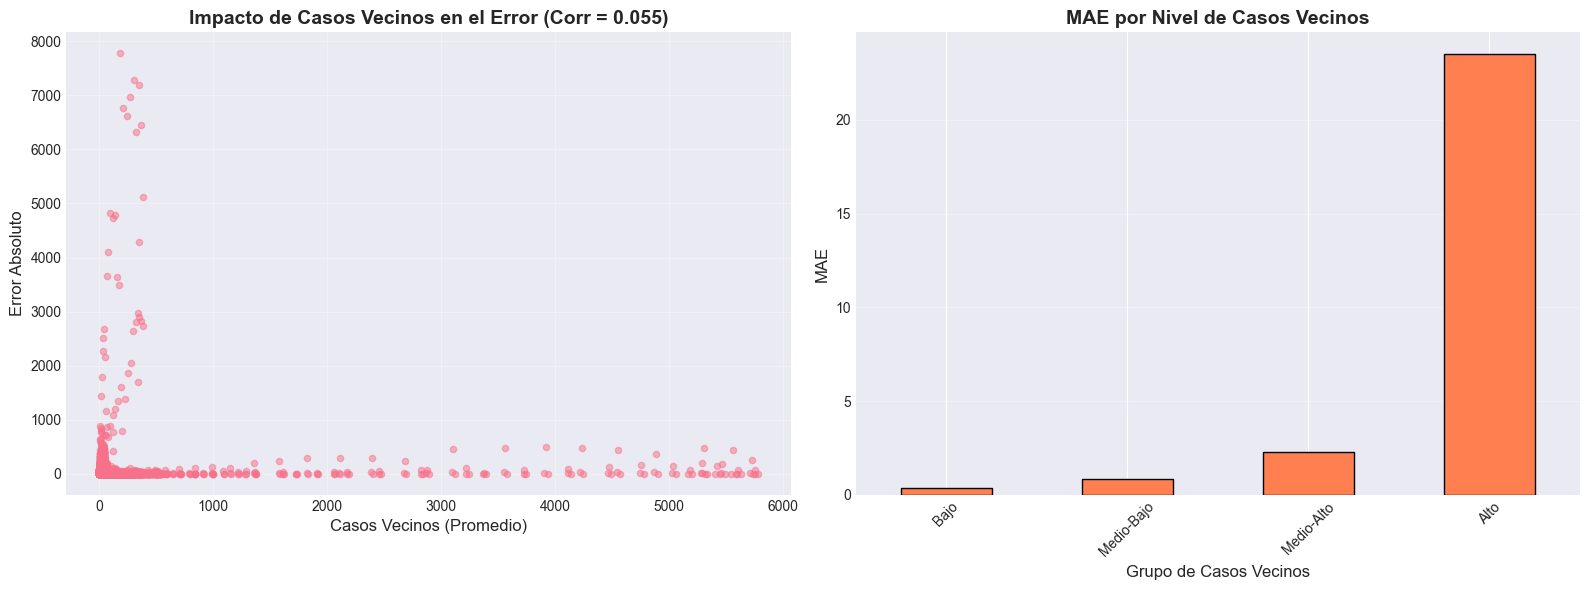

Correlación entre casos_vecinos y error: 0.055


In [17]:

# Analizar el impacto de casos_vecinos en la predicción
df_analysis = pd.DataFrame({
    'real': y_val,
    'pred': y_pred,
    'error': errors,
    'casos_vecinos': X_val[:, :, 1].mean(axis=1)  # Promedio de casos_vecinos en la ventana
})

# Correlación entre casos_vecinos y error
# Convertir a arrays de numpy explícitamente para evitar problemas
casos_vecinos_array = np.array(df_analysis['casos_vecinos'].values, dtype=float)
error_abs_array = np.array(np.abs(df_analysis['error'].values), dtype=float)

# Calcular correlación de forma segura
try:
    if len(casos_vecinos_array) > 1 and np.std(casos_vecinos_array) > 0 and np.std(error_abs_array) > 0:
        corr_vecinos = np.corrcoef(casos_vecinos_array, error_abs_array)[0, 1]
    else:
        corr_vecinos = 0.0
        print("⚠️ No se pudo calcular correlación (valores constantes o insuficientes datos)")
except Exception as e:
    corr_vecinos = 0.0
    print(f"⚠️ Error calculando correlación: {e}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: casos_vecinos vs error
axes[0].scatter(df_analysis['casos_vecinos'], np.abs(df_analysis['error']), alpha=0.5, s=20)
axes[0].set_xlabel('Casos Vecinos (Promedio)', fontsize=12)
axes[0].set_ylabel('Error Absoluto', fontsize=12)
axes[0].set_title(f'Impacto de Casos Vecinos en el Error (Corr = {corr_vecinos:.3f})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Dividir en grupos según casos_vecinos
try:
    # Intentar usar qcut, si falla usar cut
    try:
        df_analysis['grupo_vecinos'] = pd.qcut(df_analysis['casos_vecinos'], q=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], duplicates='drop')
    except ValueError:
        # Si qcut falla (valores duplicados), usar cut
        df_analysis['grupo_vecinos'] = pd.cut(df_analysis['casos_vecinos'], bins=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])
    
    mae_por_grupo = df_analysis.groupby('grupo_vecinos')['error'].apply(lambda x: np.mean(np.abs(x)))
    mae_por_grupo.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
    axes[1].set_title('MAE por Nivel de Casos Vecinos', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Grupo de Casos Vecinos', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
except Exception as e:
    print(f"⚠️ No se pudo crear gráfico de grupos: {e}")
    axes[1].text(0.5, 0.5, 'No se pudo agrupar datos', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('MAE por Nivel de Casos Vecinos', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Correlación entre casos_vecinos y error: {corr_vecinos:.3f}")


### 10.3 Análisis por Día de la Semana

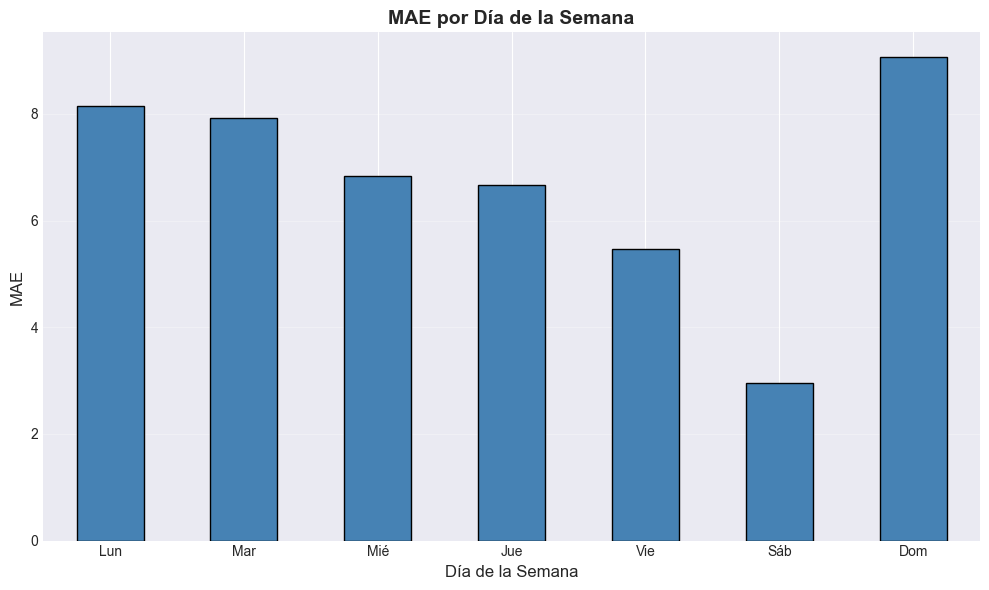

dia_semana
0.0    8.144708
1.0    7.930830
2.0    6.845360
3.0    6.665492
4.0    5.459036
5.0    2.954889
6.0    9.076381
Name: error, dtype: float32

In [18]:

# Análisis por día de la semana
df_analysis['dia_semana'] = X_val[:, -1, 3]  # Último día de la ventana
dias_nombres = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']

mae_por_dia = df_analysis.groupby('dia_semana')['error'].apply(lambda x: np.mean(np.abs(x)))

fig, ax = plt.subplots(figsize=(10, 6))
mae_por_dia.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('MAE por Día de la Semana', fontsize=14, fontweight='bold')
ax.set_xlabel('Día de la Semana', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_xticklabels([dias_nombres[int(i)] for i in mae_por_dia.index], rotation=0)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

mae_por_dia


## 11. Resumen y Conclusiones

In [19]:

print("=" * 60)
print("RESUMEN DEL ANÁLISIS DEL MODELO DE COVID-19")
print("=" * 60)
print(f"\n📊 Métricas Principales:")
print(f"   • MAE:  {mae:.4f} casos")
print(f"   • RMSE: {rmse:.4f} casos")
print(f"   • R²:   {r2:.4f}")
print(f"   • MAPE: {mape*100:.2f}%")
print(f"\n📈 Interpretación:")
if r2 > 0.7:
    print("   ✅ Excelente capacidad predictiva (R² > 0.7)")
elif r2 > 0.5:
    print("   ✅ Buena capacidad predictiva (R² > 0.5)")
elif r2 > 0.3:
    print("   ⚠️ Capacidad predictiva moderada (R² > 0.3)")
else:
    print("   ⚠️ Capacidad predictiva limitada (R² < 0.3)")

print(f"\n🎯 Recomendaciones:")
if mape > 0.3:
    print("   • Considerar agregar más features (movilidad, vacunación, etc.)")
if abs(bias) > mae * 0.2:
    print("   • Revisar el preprocesamiento para reducir el sesgo")
if r2 < 0.5:
    print("   • Considerar ajustar hiperparámetros o arquitectura del modelo")

print("\n" + "=" * 60)


RESUMEN DEL ANÁLISIS DEL MODELO DE COVID-19

📊 Métricas Principales:
   • MAE:  6.7206 casos
   • RMSE: 121.6909 casos
   • R²:   0.0016
   • MAPE: 50792135602995200.00%

📈 Interpretación:
   ⚠️ Capacidad predictiva limitada (R² < 0.3)

🎯 Recomendaciones:
   • Considerar agregar más features (movilidad, vacunación, etc.)
   • Revisar el preprocesamiento para reducir el sesgo
   • Considerar ajustar hiperparámetros o arquitectura del modelo

